# Introduction

<div class="alert alert-block alert-danger">
<b>

THIS NOTEBOOK IS A STUB, CODE IS INCOMPLETE

</b>
</div>

Preprocess:
* none, only scale to -1, 1

Generator:
* noise -> generator input is FC
* strided convolutions, ReLU
* output NO BATCH NORM, TANH

Discriminator:

* input NO BATCH NORM, LeakyReLU(.2)
* last layer is flattened, sigmoid


Optimizer:
* weight init: normal, std=0.02
* mini-batch 128
* Adam, lr=0.0002, B1=0.5

**Resources**

* [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) (2015) by Alec Radford, Luke Metz, Soumith Chintala
* [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167) (2015) by Sergey Ioffe, Christian Szegedy

Imports

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage


In [3]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# MNIST Dataset

Load MNIST Dataset from Keras API. We only need train images, ignore labels and validation set.

In [4]:
# (x_train_raw, _), (_, _) = tf.keras.datasets.mnist.load_data()

Convert to -1..1 range to mach tanh output from generator

In [5]:
# x_train = (x_train_raw-127.5) / 127.5
# x_train = x_train.reshape([len(x_train), -1])
# print('x_train.shape:', x_train.shape)
# print('x_train.min():', x_train.min())
# print('x_train.max():', x_train.max())
# print('x_train:\n', x_train)

# Celeb A

In [6]:
dataset_location = '/home/marcin/Datasets/img_align_celeba'

In [7]:
datafile = os.path.join(dataset_location, 'img_align_celeba_32x32.npz')
print(datafile)

/home/marcin/Datasets/img_align_celeba/img_align_celeba_32x32.npz


In [8]:
import PIL

In [9]:
all_files = os.listdir(os.path.join(dataset_location, 'img_align_celeba'))

In [10]:
def crop_celeba(img, size):
    assert img.size == (178, 218)
    box = [25, 65, img.width-25, img.height-25]  # crop 25/65/25/25 from left/top/right/bottom
    return img.crop(box)                         # result.size = (128, 128)

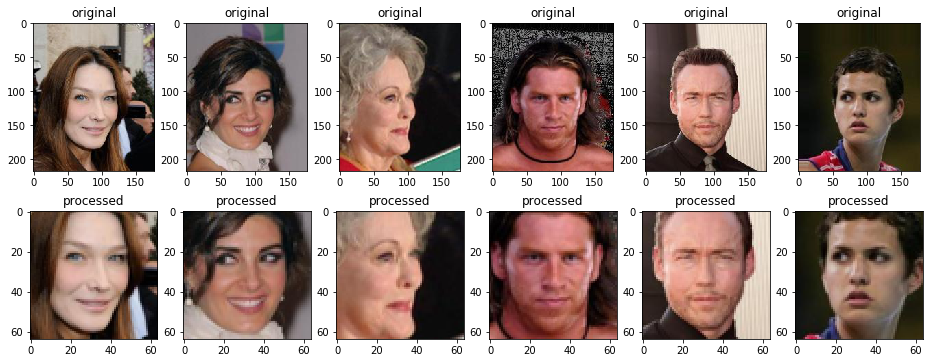

In [11]:
fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=6, figsize=[16,6])
for i in range(len(axes1)):
    idx = np.random.randint(0, len(all_files))
    img_full_path = os.path.join(dataset_location, 'img_align_celeba', all_files[idx])
    img = PIL.Image.open(img_full_path)
    img_128x128 = crop_celeba(img, None)
    img_64x64 = img_128x128.resize([64, 64], PIL.Image.BICUBIC)
    axes1[i].imshow(img)
    axes1[i].set_title('original')
    axes2[i].imshow(img_64x64)
    axes2[i].set_title('processed')

In [12]:
def load_all_images(dataset_location, all_files, size=32):
    all_images = []
    for i in range(len(all_files)):
        img_full_path = os.path.join(dataset_location, 'img_align_celeba', all_files[i])
        img = PIL.Image.open(img_full_path)
        img_128x128 = crop_celeba(img, None)
        img_small = img_128x128.resize([size, size], PIL.Image.BICUBIC)  
        arr = np.array(img_small)
        assert arr.shape == (size, size, 3)
        all_images.append(arr)
        if i % 10000 == 0:
            print(f'Image {i} of {len(all_files)}')
    return np.array(all_images)

In [13]:
if not os.path.isfile(datafile):
    print('Creating datafile...')
    all_images = load_all_images(dataset_location, all_files, size=32)
    np.savez(datafile, all_images=all_images)
else:
    print('Loading from file...')
    npzfile = np.load(datafile)
    all_images = npzfile['all_images']

Loading from file...


In [14]:
x_train = (all_images.astype(np.float32) / 127.5) - 1      # scale to range [-1..1]
x_train = x_train[:-103]                                   # make divisible by 128
x_train.shape

(202496, 32, 32, 3)

In [15]:
del all_images  # save memory

# DCGAN in Keras

Preprocess:
* none, only scale to -1, 1

Generator:
* noise -> generator input is FC
* strided convolutions, ReLU
* output NO BATCH NORM, TANH

Discriminator:

* input NO BATCH NORM, LeakyReLU(.2)
* last layer is flattened, sigmoid


Optimizer:
* weight init: normal, std=0.02
* mini-batch 128
* Adam, lr=0.0002, B1=0.5

In [16]:
init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [17]:
from tensorflow.keras.layers import InputLayer, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Cropping2D, BatchNormalization, ReLU, Activation

generator = tf.keras.Sequential(name='Generator')
generator.add(InputLayer(input_shape=(100,)))

generator.add(Dense(units=4*4*128, kernel_initializer=init, name='IN-fc'))
generator.add(Reshape((4,4,128), name='IN-reshape'))

generator.add(Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(2,2), use_bias=False, kernel_initializer=init, name='L1-convT' ))
generator.add(Cropping2D(cropping=(1,1), name='L1-crop'))
generator.add(BatchNormalization(name='L1-bn'))
generator.add(ReLU(name='L1-act'))

generator.add(Conv2DTranspose(filters=32, kernel_size=(4,4), strides=(2,2), use_bias=False, kernel_initializer=init, name='L2-convT' ))
generator.add(Cropping2D(cropping=(1,1), name='L2-crop'))
generator.add(BatchNormalization(name='L2-bn'))
generator.add(ReLU(name='L2-act'))

generator.add(Conv2DTranspose(filters=3, kernel_size=(4,4), strides=(2,2), kernel_initializer=init, name='L3-convT' ))
generator.add(Cropping2D(cropping=(1,1), name='L3-crop'))
generator.add(Activation(activation='tanh', name='L3-act'))

# generator.compile(...)                                             # no need
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IN-fc (Dense)                (None, 2048)              206848    
_________________________________________________________________
IN-reshape (Reshape)         (None, 4, 4, 128)         0         
_________________________________________________________________
L1-convT (Conv2DTranspose)   (None, 10, 10, 64)        131072    
_________________________________________________________________
L1-crop (Cropping2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
L1-bn (BatchNormalization)   (None, 8, 8, 64)          256       
_________________________________________________________________
L1-act (ReLU)                (None, 8, 8, 64)          0         
_________________________________________________________________
L2-convT (Conv2DTranspose)   (None, 18, 18, 32)        32768     
__________

In [18]:
dense1 = generator.layers[0].get_weights()[0]
print('IN-fc', dense1.mean(), dense1.std())
conv1 = generator.layers[2].get_weights()[0]
print('L1-convT', conv1.mean(), conv1.std())
conv2 = generator.layers[6].get_weights()[0]
print('L2-convT', conv2.mean(), conv2.std())
conv3 = generator.layers[10].get_weights()[0]
print('L3-convT', conv3.mean(), conv3.std())

IN-fc 6.084958e-06 0.019909134
L1-convT 4.261781e-05 0.019960444
L2-convT -0.00021587624 0.019923147
L3-convT -0.00041455295 0.019933777


In [19]:
from tensorflow.keras.layers import InputLayer, Conv2D, LeakyReLU, ZeroPadding2D, BatchNormalization, Flatten, Dense

# Full DCGAN 128x128
# discriminator = tf.keras.Sequential(name='Discriminator')
# discriminator.add(InputLayer(input_shape=(64, 64, 3), name='DiscInput'))
# discriminator.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same', activation=LeakyReLU(.2)))
# discriminator.add(Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='same', activation=LeakyReLU(.2)))
# discriminator.add(Conv2D(filters=512, kernel_size=(5,5), strides=(2,2), padding='same', activation=LeakyReLU(.2)))
# discriminator.add(Conv2D(filters=1024, kernel_size=(5,5), strides=(2,2), padding='same', activation=LeakyReLU(.2)))
# discriminator.add(Flatten())
# discriminator.add(Dense(units=1, activation='sigmoid'))
# discriminator.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')
# discriminator.summary()

# Version Lite 32x32
discriminator = tf.keras.Sequential(name='Discriminator')
discriminator.add(InputLayer(input_shape=(32, 32, 3)))

discriminator.add(ZeroPadding2D(padding=(1,1), name='L1-pad'))
discriminator.add(Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), kernel_initializer=init, name='L1-conv'))
discriminator.add(LeakyReLU(0.2, name='L1-act'))

discriminator.add(ZeroPadding2D(padding=(1,1), name='L2-pad'))
discriminator.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), kernel_initializer=init, use_bias=False, name='L2-conv'))
discriminator.add(BatchNormalization(name='L2-bn'))
discriminator.add(LeakyReLU(0.2, name='L2-act'))

discriminator.add(ZeroPadding2D(padding=(1,1), name='L3-pad'))
discriminator.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2,2), kernel_initializer=init, use_bias=False, name='L3-conv'))
discriminator.add(BatchNormalization(name='L3-bn'))
discriminator.add(LeakyReLU(0.2, name='L3-act'))

discriminator.add(Flatten(name='FC-flatten'))
discriminator.add(Dense(units=1, activation='sigmoid', kernel_initializer=init, name='FC'))

discriminator.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1-pad (ZeroPadding2D)       (None, 34, 34, 3)         0         
_________________________________________________________________
L1-conv (Conv2D)             (None, 16, 16, 32)        1568      
_________________________________________________________________
L1-act (LeakyReLU)           (None, 16, 16, 32)        0         
_________________________________________________________________
L2-pad (ZeroPadding2D)       (None, 18, 18, 32)        0         
_________________________________________________________________
L2-conv (Conv2D)             (None, 8, 8, 64)          32768     
_________________________________________________________________
L2-bn (BatchNormalization)   (None, 8, 8, 64)          256       
_________________________________________________________________
L2-act (LeakyReLU)           (None, 8, 8, 64)          0         
__________

In [20]:
conv1 = discriminator.layers[1].get_weights()[0]
print('L1-conv', conv1.mean(), conv1.std())
conv2 = discriminator.layers[4].get_weights()[0]
print('L2-conv', conv2.mean(), conv2.std())
conv3 = discriminator.layers[8].get_weights()[0]
print('L3-conv', conv3.mean(), conv3.std())

dense = discriminator.layers[12].get_weights()[0]
print('FC', dense.mean(), dense.std())

L1-conv 0.0009423348 0.020325415
L2-conv -0.00012918634 0.019984964
L3-conv -5.311329e-05 0.020042282
FC 2.5622809e-05 0.0199406


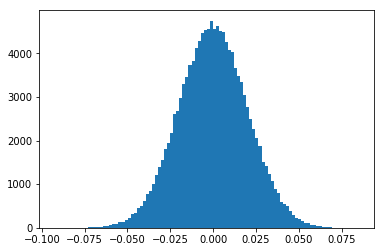

In [21]:
plt.hist(conv3.flatten(), bins=100);

In [22]:
discriminator.trainable = False                                  # must make non-trainable before compiling gan_model
gan_model = tf.keras.Sequential(name='GAN')                      # (this doesn't affect anything we done earlier)a
gan_model.add(InputLayer(input_shape=(100,), name='GANInput'))
gan_model.add(generator)
gan_model.add(discriminator)
gan_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 32, 32, 3)         372611    
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 168225    
Total params: 540,836
Trainable params: 372,419
Non-trainable params: 168,417
_________________________________________________________________


In [23]:
def plot_images(x_fake):
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=[16,9])
    for i, ax in enumerate(axes):
        ax.imshow(x_fake[i]/2+.5)
        ax.axis('off')
    plt.show()

def plot_loss(losses):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(losses['disc'], label='disc')
    ax.plot(losses['gen'], label='gen')
    plt.show()

In [24]:
n_batch = 128
n_epochs = 100   # <- set this to ~100 to see more reasonable results

epoch 46.011105s:   0     gloss: 0.29     dloss: 0.33


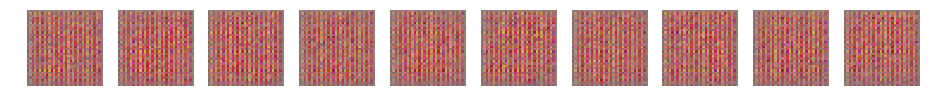

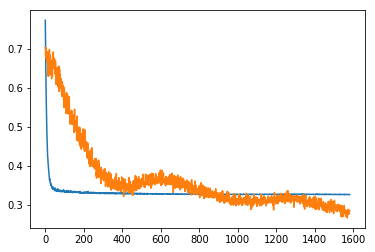

epoch 42.556123s:   1     gloss: 0.19     dloss: 0.33


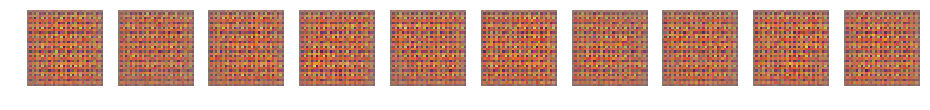

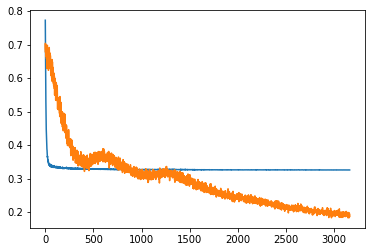

epoch 43.028522s:   2     gloss: 0.13     dloss: 0.33


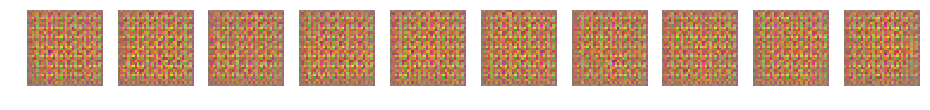

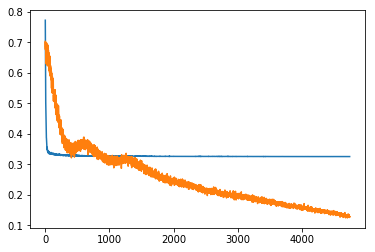

epoch 42.353074s:   3     gloss: 0.11     dloss: 0.33


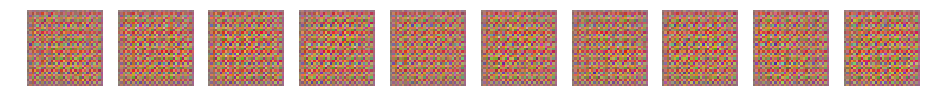

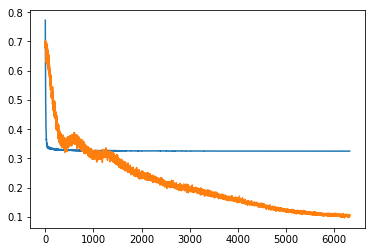

epoch 41.421560s:   4     gloss: 0.10     dloss: 0.33


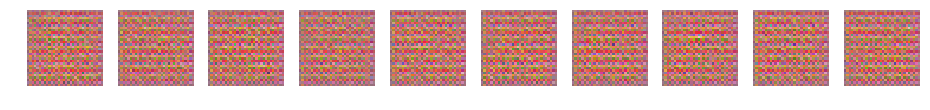

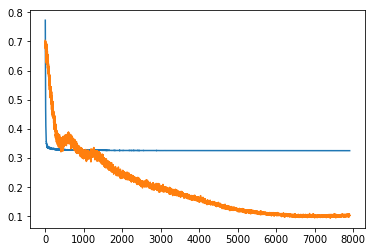

epoch 41.401195s:   5     gloss: 0.09     dloss: 0.33


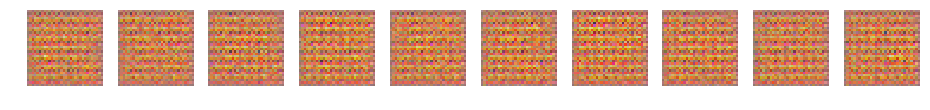

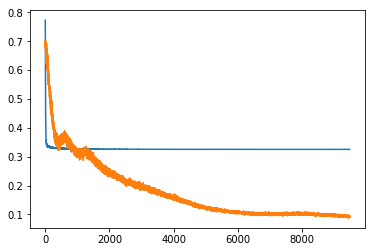

epoch 43.099194s:   6     gloss: 0.10     dloss: 0.33


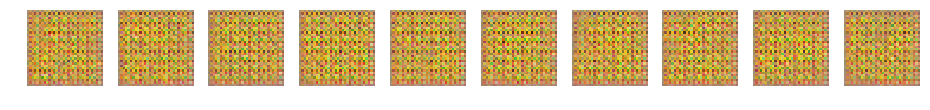

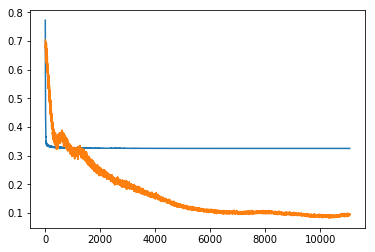

epoch 42.688130s:   7     gloss: 0.09     dloss: 0.33


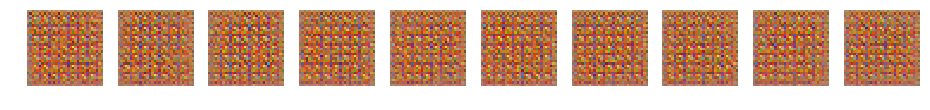

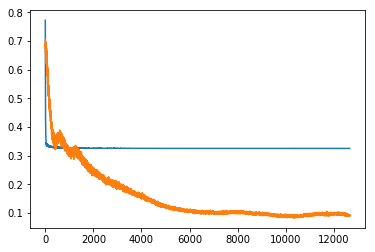

epoch 42.822405s:   8     gloss: 0.08     dloss: 0.33


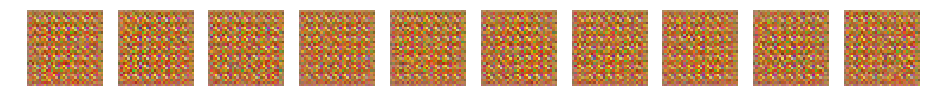

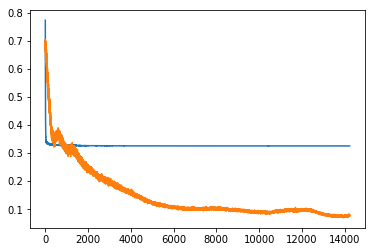

epoch 42.945229s:   9     gloss: 0.08     dloss: 0.33


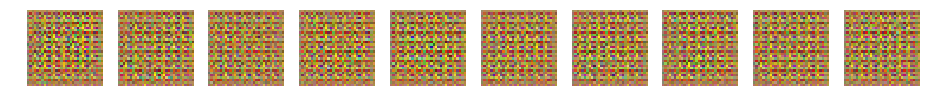

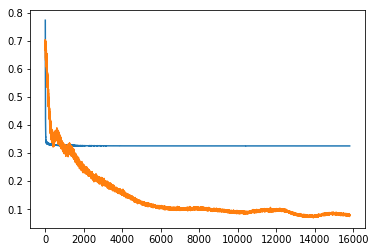

epoch 41.960160s:  10     gloss: 0.08     dloss: 0.33


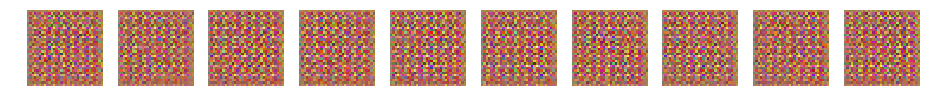

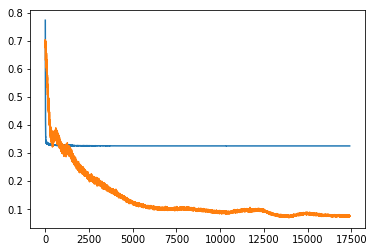

epoch 42.061762s:  11     gloss: 0.08     dloss: 0.33


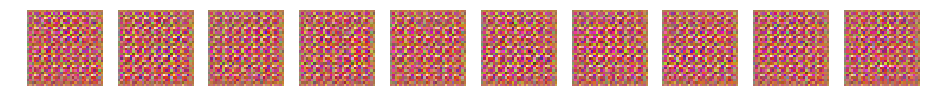

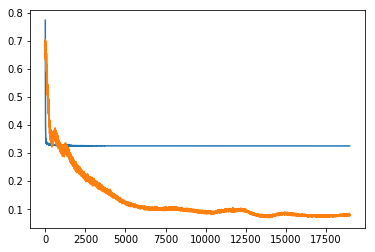

KeyboardInterrupt: 

In [25]:
losses = {'gen':[], 'disc':[]}
indices = np.array(range(len(x_train)))

for e in range(n_epochs):
    
    time_start = time.time()
    
    np.random.shuffle(indices)
    for i in range(0, len(x_train), n_batch):
        
        # Generate fake images
        noise = np.random.uniform(-1, 1, size=[n_batch, 100])             # shape (n_batch, n_rand)
        x_fake = generator.predict(noise, batch_size=n_batch)     # shape (n_batch, n_data)
        
        # Pick next batch of real images
        i_batch = indices[i:i+n_batch]
        x_real = x_train[i_batch]
        
        # Join real and fake into one batch
        x_all = np.concatenate([x_real, x_fake])
        y_all = np.concatenate([.9 * np.ones([n_batch,1]),        # use .9 instead 1 as discriminator target
                                np.ones([n_batch,1])])           # this is called 'smoothing' and improves learning

        # Train discriminator
        discriminator.trainable = True                            # get rid of warning messages (doesn't affect training)
        dloss = discriminator.train_on_batch(x_all, y_all)        # this trains only discriminator, doesn't touch gen.
        
        noise = np.random.uniform(-1, 1, size=[n_batch, 100])
        y_fake = np.ones([n_batch, 1])
        discriminator.trainable = False                           # get rid of warning messages 
        gloss = gan_model.train_on_batch(noise, y_fake)
        
        losses['disc'].append(dloss)
        losses['gen'].append(gloss)
        
    time_epoch = time.time() - time_start
    print(f'epoch {time_epoch:2f}s: {e:3}     gloss: {gloss:4.2f}     dloss: {dloss:4.2f}')
    plot_images(x_fake)
    plot_loss(losses)

In [ ]:
# generator.save('./models/generator.h5')
# discriminator.save('./models.discriminator.h5')
# gan_model.save('./models/gan_model.h5')

# Reference

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [ ]:
class DCGAN():
    def __init__(self, img_size, n_channels):
        # Input shape
        self.img_rows = img_size
        self.img_cols = img_size
        self.channels = n_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        print('Generator:')
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        print('Discriminator:')
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, epochs, batch_size=128, save_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            self.discriminator.trainable = False
            g_loss = self.combined.train_on_batch(noise, valid)
            self.discriminator.trainable = True

            # Plot the progress
            if epoch % 50 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [ ]:
# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

In [ ]:
dcgan = DCGAN(img_size=28, n_channels=1)

In [ ]:
dcgan.train(X_train=X_train, epochs=4000, batch_size=32, save_interval=50)